In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
import numpy as np
import scipy.stats
import string
import time
from itertools import chain

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import *
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)

<IPython.core.display.Javascript object>

In [63]:
filepath = "../data/clean_data.csv"
filepath_replaced = "../data/clean_data_replaced.csv"

<IPython.core.display.Javascript object>

In [64]:
df = pd.read_csv(filepath, encoding="utf_8")
df_replaced = pd.read_csv(filepath_replaced, encoding="utf_8")

<IPython.core.display.Javascript object>

In [10]:
df.groupby("label").count()

,text
label,
"Austen, Jane",9961
"Christie, Agatha",12354
"Dickens, Charles",25037
"Dostoyevsky, Fyodor",15421
"Hugo, Victor",23405
"London, Jack",11843
"Stowe, Harriett Beecher",12794
"Twain, Mark",10837


<IPython.core.display.Javascript object>

In [11]:
df_replaced.groupby("label").count()

,text
label,
"Austen, Jane",9961
"Christie, Agatha",12354
"Dickens, Charles",25037
"Dostoyevsky, Fyodor",15421
"Hugo, Victor",23405
"London, Jack",11843
"Stowe, Harriett Beecher",12794
"Twain, Mark",10837


<IPython.core.display.Javascript object>

In [12]:
df.head(5)

,text,label
0,"My father’s family name being Pirrip, and my C...","Dickens, Charles"
1,"I give Pirrip as my father’s family name, on t...","Dickens, Charles"
2,"Ours was the marsh country, down by the river,...","Dickens, Charles"
3,"“Hold your noise!” cried a terrible voice, as ...","Dickens, Charles"
4,"A fearful man, all in coarse grey, with a grea...","Dickens, Charles"


<IPython.core.display.Javascript object>

In [13]:
df_replaced.head(5)

,text,label
0,My father’s family name being NNP and my Chris...,"Dickens, Charles"
1,I give NNP as my father’s family name on the a...,"Dickens, Charles"
2,NNP was the marsh country down by the river wi...,"Dickens, Charles"
3,“Hold your noise!” cried a terrible voice as a...,"Dickens, Charles"
4,A fearful man all in coarse grey with a great ...,"Dickens, Charles"


<IPython.core.display.Javascript object>

# Functions

In [65]:
def fit_model_tfidf(model, X_train, X_test, y_train, y_test, use_bigrams=False):

    start_time = time.time()

    # Vectorize
    if use_bigrams == True:
        count_vect = CountVectorizer(ngram_range=(2, 2), max_df=0.7, min_df=5)
    else:
        count_vect = CountVectorizer(max_df=0.7, min_df=5)
    tfidf_transformer = TfidfTransformer()

    X_train_counts = count_vect.fit_transform(X_train)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

    # Train model
    clf = model.fit(X_train_tfidf, y_train)

    # Apply vectorization on test set
    X_test_counts = count_vect.transform(X_test)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)

    # Predict on test
    y_pred = clf.predict(X_test_tfidf)

    end_time = time.time()

    print("Accuracy is: %f" % accuracy_score(y_pred, y_test))
    print("Precision is: %f" % precision_score(y_pred, y_test, average="macro"))
    print("Recall is: %f" % recall_score(y_pred, y_test, average="macro"))
    print("F1 score is: %f" % f1_score(y_pred, y_test, average="macro"))
    print("Execution time: %0.2fs" % (end_time - start_time))

    return clf, count_vect, tfidf_transformer

<IPython.core.display.Javascript object>

In [67]:
def get_confusion_matrix(X, y_true, model, count_vect, tfidf_transformer):

    text_counts = count_vect.transform(X)
    text_tfidf = tfidf_transformer.transform(text_counts)

    # Predicted label
    y_pred = model.predict(text_tfidf)

    # Confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred, normalize="true")
    df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index=np.unique(y_true))
    df_cm.index.name = "Actual"
    df_cm.columns.name = "Predicted"

    return df_cm

<IPython.core.display.Javascript object>

In [68]:
def predict_text_print(text, label, model, count_vect, tfidf_transformer):

    text_counts = count_vect.transform(text)
    text_tfidf = tfidf_transformer.transform(text_counts)

    predict_label = model.predict(text_tfidf)
    predict_prob = model.decision_function(text_tfidf)

    output = pd.DataFrame(
        {"TEXT": text, "PREDICTED LABEL": predict_label, "ACTUAL LABEL": label}
    )
    parsed = json.loads(output.to_json(orient="index"))
    output_json = json.dumps(parsed, indent=4)

    print(output_json)

<IPython.core.display.Javascript object>

# Setup

In [69]:
# texts, labels = get_texts_and_labels(df)
texts = list(df["text"])
texts_replaced = list(df_replaced["text"])
labels = list(df["label"])

<IPython.core.display.Javascript object>

In [70]:
# Split into train / test set
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=414
)

<IPython.core.display.Javascript object>

In [71]:
# Split into train / test set
X_train_replaced, X_test_replaced, y_train_replaced, y_test_replaced = train_test_split(
    texts_replaced, labels, test_size=0.2, random_state=414
)

<IPython.core.display.Javascript object>

# Models

## Logistic Regression

In [72]:
# Define models
model_lr1 = LogisticRegression(solver="liblinear", multi_class="ovr", random_state=414)
model_lr2 = LogisticRegression(
    solver="liblinear", multi_class="ovr", class_weight="balanced", random_state=414
)

<IPython.core.display.Javascript object>

In [73]:
# Fit model
clf_lr1, count_vect1, tfidf_transformer1 = fit_model_tfidf(
    model_lr1, X_train, X_test, y_train, y_test, use_bigrams=False
)

Accuracy is: 0.799967
Precision is: 0.780753
Recall is: 0.816283
F1 score is: 0.795355
Execution time: 22.98s


<IPython.core.display.Javascript object>

In [74]:
# Fit model using balanced class weights
clf_lr2, count_vect1, tfidf_transformer1 = fit_model_tfidf(
    model_lr2, X_train, X_test, y_train, y_test, use_bigrams=False
)

Accuracy is: 0.801940
Precision is: 0.796638
Recall is: 0.795609
F1 score is: 0.795584
Execution time: 23.69s


<IPython.core.display.Javascript object>

In [23]:
# Fit model using bigrams
clf_lr3, count_vect1_1, tfidf_transformer1_1 = fit_model_tfidf(
    model_lr1, X_train, X_test, y_train, y_test, use_bigrams=True
)

Accuracy is: 0.707123
Precision is: 0.670567
Recall is: 0.748445
F1 score is: 0.695618
Execution time: 21.92s


<IPython.core.display.Javascript object>

### Fit model on replaced text

In [75]:
clf_lr1_replaced, count_vect1_replaced, tfidf_transformer1_replaced = fit_model_tfidf(
    model_lr1,
    X_train_replaced,
    X_test_replaced,
    y_train_replaced,
    y_test_replaced,
    use_bigrams=False,
)

Accuracy is: 0.670256
Precision is: 0.641014
Recall is: 0.682624
F1 score is: 0.655846
Execution time: 23.65s


<IPython.core.display.Javascript object>

## SVM

In [76]:
# Define models
model_svm1 = LinearSVC(multi_class="ovr", random_state=414)
model_svm2 = LinearSVC(C=0.5, multi_class="ovr", random_state=414)
model_svm3 = LinearSVC(C=2.0, multi_class="ovr", random_state=414)

model_svm4 = LinearSVC(
    C=0.5, multi_class="ovr", class_weight="balanced", random_state=414
)

<IPython.core.display.Javascript object>

In [26]:
# Fit model
clf_svm1, count_vect2, tfidf_transformer2 = fit_model_tfidf(
    model_svm1, X_train, X_test, y_train, y_test, use_bigrams=False
)

Accuracy is: 0.822490
Precision is: 0.810706
Recall is: 0.826716
F1 score is: 0.817892
Execution time: 9.54s


<IPython.core.display.Javascript object>

In [84]:
clf_svm2, count_vect2, tfidf_transformer2 = fit_model_tfidf(
    model_svm2, X_train, X_test, y_train, y_test, use_bigrams=False
)

Accuracy is: 0.824750
Precision is: 0.811733
Recall is: 0.831519
F1 score is: 0.820432
Execution time: 10.25s


<IPython.core.display.Javascript object>

In [28]:
clf_svm3, count_vect2, tfidf_transformer2 = fit_model_tfidf(
    model_svm3, X_train, X_test, y_train, y_test, use_bigrams=False
)

Accuracy is: 0.818215
Precision is: 0.806488
Recall is: 0.820518
F1 score is: 0.812847
Execution time: 12.39s


<IPython.core.display.Javascript object>

In [29]:
clf_svm4, count_vect2, tfidf_transformer2 = fit_model_tfidf(
    model_svm4, X_train, X_test, y_train, y_test, use_bigrams=False
)

Accuracy is: 0.823558
Precision is: 0.819743
Recall is: 0.814928
F1 score is: 0.816974
Execution time: 9.18s


<IPython.core.display.Javascript object>

In [30]:
clf_svm5, count_vect2_2, tfidf_transformer2_2 = fit_model_tfidf(
    model_svm2, X_train, X_test, y_train, y_test, use_bigrams=True
)

Accuracy is: 0.749003
Precision is: 0.727941
Recall is: 0.758171
F1 score is: 0.739899
Execution time: 17.60s


<IPython.core.display.Javascript object>

### Fit model on replaced text

In [78]:
clf_svm2_replaced, count_vect2_replaced, tfidf_transformer2_replaced = fit_model_tfidf(
    model_svm2,
    X_train_replaced,
    X_test_replaced,
    y_train_replaced,
    y_test_replaced,
    use_bigrams=False,
)

Accuracy is: 0.691751
Precision is: 0.670451
Recall is: 0.696315
F1 score is: 0.680291
Execution time: 12.20s


<IPython.core.display.Javascript object>

# Visualize Results

In [79]:
cf_matrix1 = get_confusion_matrix(
    X_test, y_test, clf_lr2, count_vect1, tfidf_transformer1
)

<IPython.core.display.Javascript object>

In [93]:
cf_matrix2 = get_confusion_matrix(
    X_test, y_test, clf_svm2, count_vect2, tfidf_transformer2
)

<IPython.core.display.Javascript object>

In [81]:
cf_matrix1_replaced = get_confusion_matrix(
    X_test_replaced,
    y_test_replaced,
    clf_lr1_replaced,
    count_vect1_replaced,
    tfidf_transformer1_replaced,
)

<IPython.core.display.Javascript object>

In [82]:
cf_matrix2_replaced = get_confusion_matrix(
    X_test_replaced,
    y_test_replaced,
    clf_svm2_replaced,
    count_vect2_replaced,
    tfidf_transformer2_replaced,
)

<IPython.core.display.Javascript object>

In [87]:
def create_cf_viz(cf, model_name, colors="Blues"):

    fig, ax = plt.subplots(figsize=(12, 8))

    sns.set(font_scale=1.2)
    sns.heatmap(
        cf, cmap=colors, vmin=0, vmax=1, annot=True, annot_kws={"size": 14},
    )

    ax.set_title("Actual vs. Predicted Labels: " + model_name)
    plt.xticks(rotation=45)

    plt.show()

<IPython.core.display.Javascript object>

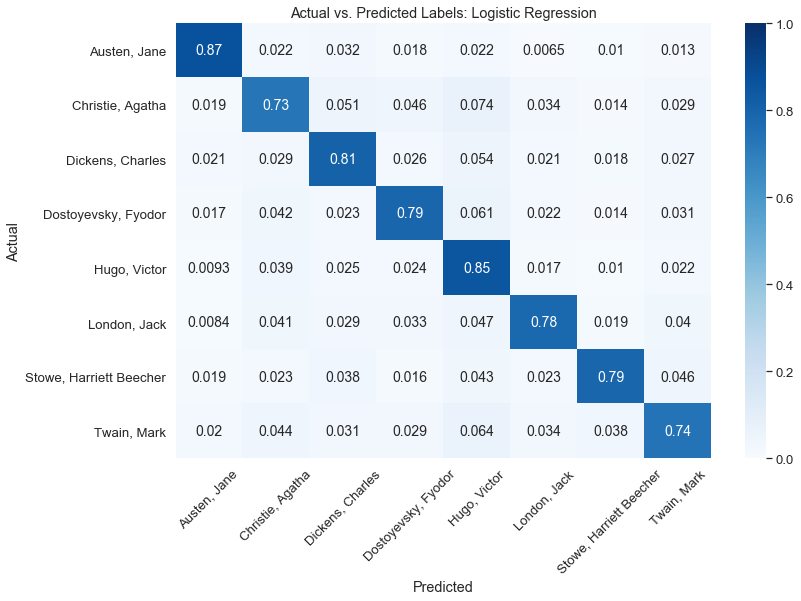

<IPython.core.display.Javascript object>

In [88]:
create_cf_viz(cf_matrix1, "Logistic Regression")

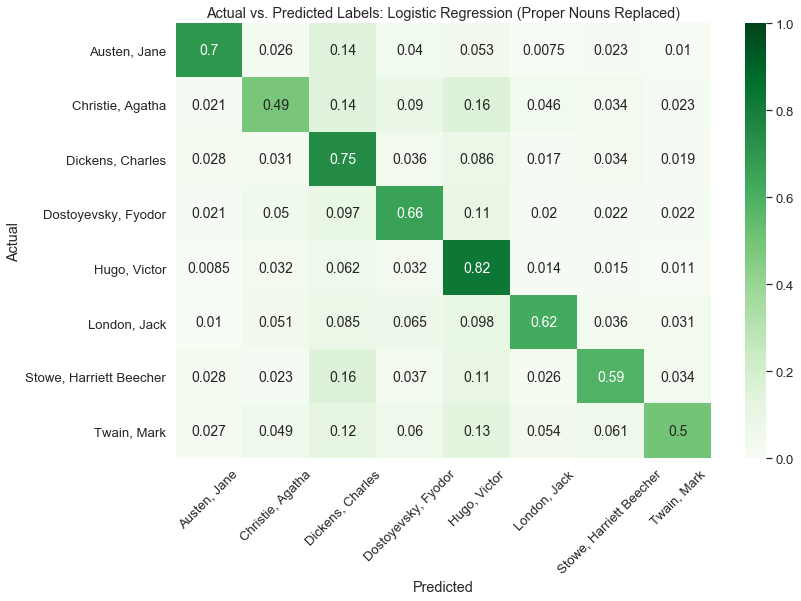

<IPython.core.display.Javascript object>

In [89]:
create_cf_viz(
    cf_matrix1_replaced, "Logistic Regression (Proper Nouns Replaced)", colors="Greens"
)

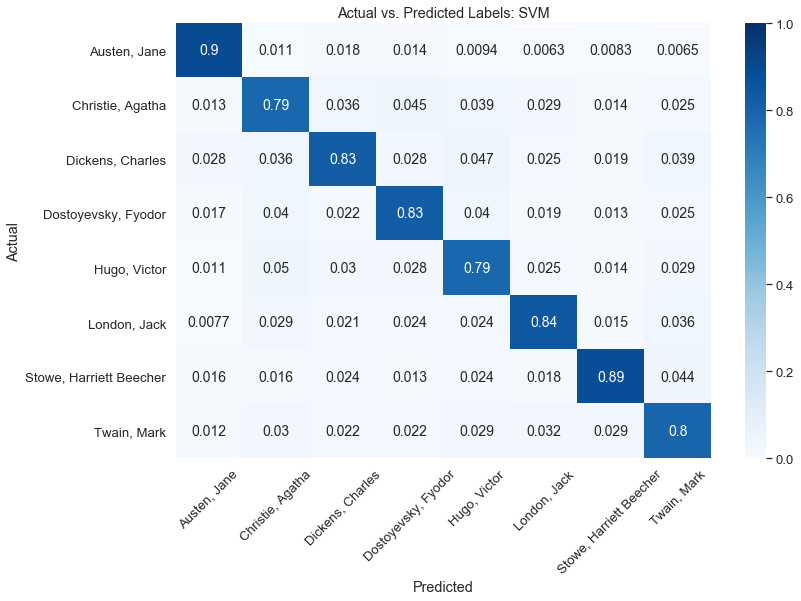

<IPython.core.display.Javascript object>

In [44]:
create_cf_viz(cf_matrix2, "SVM")

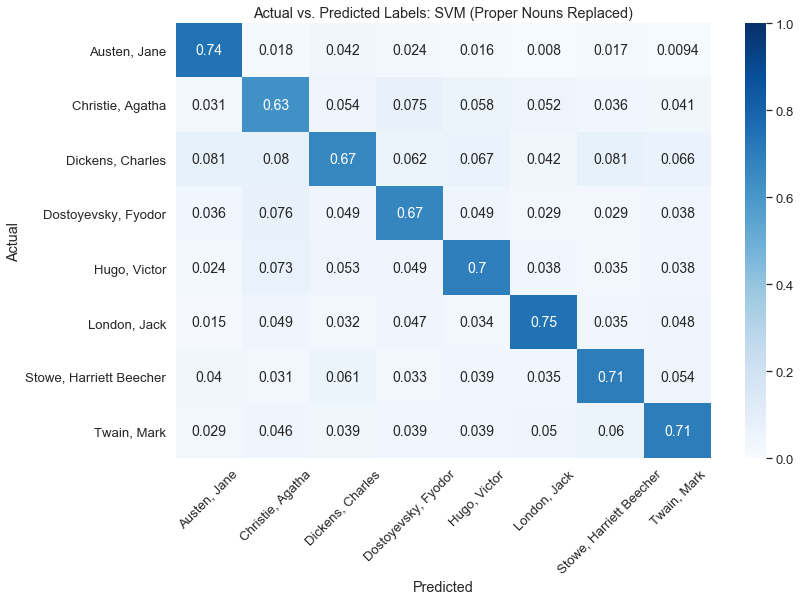

<IPython.core.display.Javascript object>

In [45]:
create_cf_viz(cf_matrix2_replaced, "SVM (Proper Nouns Replaced)")

# Predict

In [46]:
sample_index = [
    0,
    5000,
    10000,
    20000,
    30000,
    40000,
    50000,
    60000,
    70000,
    80000,
    90000,
    10000,
    110000,
]

<IPython.core.display.Javascript object>

In [47]:
# Sample text
sample_text = [texts_replaced[i] for i in sample_index]

# Sample labels
sample_labels = [labels[i] for i in sample_index]

<IPython.core.display.Javascript object>

In [48]:
predict_text_print(
    sample_text,
    sample_labels,
    clf_lr1_replaced,
    count_vect1_replaced,
    tfidf_transformer1_replaced,
)

{
    "0": {
        "TEXT": "My father\u2019s family name being NNP and my Christian name NNP my infant tongue could make of both names nothing longer or more explicit than NNP So I called myself NNP and came to be called NNP",
        "PREDICTED LABEL": "Dickens, Charles",
        "ACTUAL LABEL": "Dickens, Charles"
    },
    "1": {
        "TEXT": "I doubt if he had ever once thought of it before",
        "PREDICTED LABEL": "Dickens, Charles",
        "ACTUAL LABEL": "Dickens, Charles"
    },
    "2": {
        "TEXT": "With this peroration NNP NNP buttoned up goes quietly out looking steadily before him as if he were already piercing the night in quest of the fugitive",
        "PREDICTED LABEL": "Dickens, Charles",
        "ACTUAL LABEL": "Dickens, Charles"
    },
    "3": {
        "TEXT": "Among the talkers was NNP of the NNP NNP NNP far on his way to state promotion and therefore loud on the theme broaching to NNP his devices for blowing the people up and exterminating them fr

<IPython.core.display.Javascript object>